## Data Augmentation

In [1]:
from scipy.io import wavfile as wav
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
from pathlib import Path
from sklearn.model_selection import train_test_split

In [26]:
def add_noise(file_path):
    data = librosa.core.load(file_path)[0]
    noise = np.random.randn(len(data))
    data_noise = data + 0.005 * noise
    return data_noise
 
def shift(file_path):
    data = librosa.core.load(file_path)[0]
    return np.roll(data, 300)
 
def stretch(file_path):
    data = librosa.core.load(file_path)[0]
    rate=0.25
    data = librosa.effects.time_stretch(data, rate)
    return data
 
def write_audio_file(file, data, sample_rate=22050):
    librosa.output.write_wav(file, data, sample_rate)
    
    
def new_name (source_str, insert_str):
    #return source_str[:-4]+insert_str+source_str[-4:]
    return source_str[:34] + str('Augmented/') + source_str[34:-4] + insert_str + source_str[-4:]


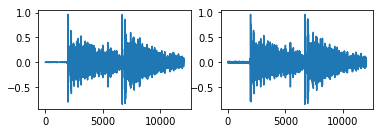

In [56]:
path = '../../../Source/Clean_train_clips/Shuffle/1/1.wav'
y, sr = librosa.load(path)
plt.subplot(221)
plt.plot(y)

plt.subplot(222)
plt.plot(add_noise(path));
add_noise(path);


### Getting all the cleaned data in one list

In [3]:
shuffle_col=[]
pathlist = Path('../../../Source/Clean_train_clips/Shuffle').glob('**/*.wav')
for path in pathlist:
    shuffle_col.append(path)

In [4]:
bc_col = []
pathlist = Path('../../../Source/Clean_train_clips/Ball_change').glob('**/*.wav')
for path in pathlist:
    bc_col.append(path)
    bc_col.sort()

In [5]:
path_col = shuffle_col + bc_col

### Set aside some data for validation

In [6]:
len(path_col)

343

In [7]:
path_copy = path_col.copy()

In [8]:
def get_label(path):
    if path.parts[-3] == 'Shuffle':
        return 1
    else:
        return 0

In [9]:
path_df = pd.DataFrame(path_copy, columns=['Path'])
path_df['Labels'] = [get_label(path_df.loc[idx,'Path']) for idx in range(len(path_df))]

In [10]:
X = path_df['Path']
y = path_df['Labels']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=(1/3))

In [12]:
X_test.to_csv('../../../Source/Data/X_test_preAugmented.csv', index=None)
y_test.to_csv('../../../Source/Data/y_test_preAugmented.csv', index=None)

In [13]:
X_train.shape, X_test.shape
y_train.shape, y_test.shape

((228,), (115,))

In [14]:
path_col = (X_train.tolist())
len(path_col)

228

### Creating, exporting noisy clips

In [15]:
for i in range (len(path_col)): 
    write_audio_file((new_name(str(path_col[i]), '_noise')),
                      add_noise(path_col[i]))

### Creating, exporting stretched clips

In [16]:
for i in range (len(path_col)): 
    write_audio_file((new_name(str(path_col[i]), '_stretch')),
                      stretch(path_col[i]))

### Creating, exporting shifted clips

In [17]:
for i in range (len(path_col)): 
    write_audio_file((new_name(str(path_col[i]), '_shift')),
                      shift(path_col[i]))

### Export un-augmented data

In [23]:
#train_untrans = pd.DataFrame(path_col, columns=['Path'])

In [25]:
#train_untrans.to_csv('../../../Source/Data/X_train_preAugmented.csv', index=None)